In [12]:
import pandas as pd
from datetime import datetime
import glob
# rasterize the ROI for model training
def vector_rasterize(dir_vector, dir_raster, dir_out, flag_output):
    vector = gpd.read_file(dir_vector)
    # Get list of geometries for all features in vector file
    geom = [shapes for shapes in vector.geometry]

    # Open example raster
    raster = rasterio.open(dir_raster)
    
    # reproject vector to raster
    vector = vector.to_crs(raster.crs)

    # create tuples of geometry, value pairs, where value is the attribute value you want to burn
    geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector['label']))

    # Rasterize vector using the shape and transform of the raster
    rasterized = features.rasterize(geom_value,
                                    out_shape = raster.shape,
                                    transform = raster.transform,
                                    all_touched = True,
                                    fill = 9,   # background value
                                    merge_alg = MergeAlg.replace,
                                    dtype = np.float32)


    if flag_output:
        with rasterio.open(
                dir_out, "w",
                driver = "GTiff",
                transform = raster.transform,
                dtype = rasterio.float32,
                count = 1,
                width = raster.width,
                height = raster.height) as dst:
            dst.write(rasterized, indexes = 1)
    return rasterized

#### Step 0: select images for model training. 
The selected images were acquired within two days of ASO acquision (20210224 in Tuolumne).

In [8]:
dir_download_hls = './HLS_data/stack_train.csv'
if True:
    stack_df = pd.read_csv(dir_download_hls)
    stack_df = stack_df.dropna()
    stack_df['Date'] = [datetime.strptime(d[0:7],'%Y%j') for d in stack_df.date]
    stack_df['datestr'] = [datetime.strftime(d,'%Y%m%d') for d in stack_df.Date]
    # stack_df
    dr = pd.date_range(datetime.strptime('20210425','%Y%m%d'),datetime.strptime('20210502','%Y%m%d'), freq = '1D')
    dr = [datetime.strftime(i, "%Y%m%d") for i in dr]
    dd = [i for i in dr if i in list(stack_df.datestr)]
    print(dd)

    for i in stack_df[stack_df.datestr =='20210501'].local_links.unique():
        !cp {i} ./data/HLS_train/

['20210501']


#### Step 1: read all downloaded data 
The local and s3 links of the downloaded data are saved in the stack.csv file which was generated during the data downloading

In [3]:
%%time
# this will takes a while (6min 36s)
# read the .csv file with S3 links
dir_download_hls = './HLS_data/stack.csv'
hls_ds = read_hls(dir_download_hls)
hls_ds_temp = hls_ds
hls_ds_temp

Total images: 1116
16
CPU times: user 6min 33s, sys: 3.16 s, total: 6min 36s
Wall time: 6min 36s


,Array,Chunk
Bytes,406.73 GiB,512.00 kiB
Shape,"(1116, 6994, 6994)","(1, 256, 256)"
Count,4357668 Tasks,938556 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,406.73 GiB,512.00 kiB
Shape,"(1116, 6994, 6994)","(1, 256, 256)"
Count,4357668 Tasks,938556 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


### Step 1: Rasterize ROI and save samples to a csv file. 
This step is not necessary if the samples are already collected. If new ROIs are added, then we need to run this step again to include new sample into the sample csv file. The sample csv file is named with the sample size.

In [13]:
flag_rasterize = True
tag = 'T11SKC.2021056'
dir_ROI = "./data/ROI/HLS.S30.T11SKC.2021056_ROI.shp"
dir_raster = "./data/HLS_train/"
dir_ROIraster = './data/ROI/ROI_HLS.S30.T11SKC.2021056.tif'
dir_samples_root = './data/samples/sample_'
dir_samples = './data/samples/sample_HLS_2021056.csv'

if flag_rasterize:
    flag_output = True
    # rasterize ROI
    fn = glob.glob(dir_raster + '/*' +tag+'*B*.tif')
    fn.sort()
    ROI = vector_rasterize(dir_vector=dir_ROI, dir_raster=fn[0], dir_out=dir_ROIraster, flag_output = flag_output)
    
    # save surface reflectance and lable to csv file
    N_scale = 10000.0
    df = pd.DataFrame()
    for i in range(len(fn)):
        band_name = [n.split('.')[-2] for n in fn]
        r = rasterio.open(fn[i])
        data = pd.DataFrame(r.read().squeeze().reshape(r.height * r.width,1))
        df = pd.concat([df, data], axis=1)
        
    df_img = df/N_scale
    df_img.columns = band_name
    
    ROI = rasterio.open(dir_ROIraster)
    df_label = pd.DataFrame(ROI.read().reshape([1,-1]).T)
    df_label.columns = ['label']
    df_train = pd.concat([df_img, df_label], axis = 1)

    df_train['ndvi'] = (df_train['B08']-df_train['B04'])/(df_train['B08']+df_train['B04'])#(nir-red)/(nir+red)
    
    df_train = df_train[df_train.label !=9]
    df_train.label = np.where(df_train.label > 0, 1, 0)
    dir_samples = dir_samples_root + str(int(len(df_train.index)/1000)) + 'k.csv'
    df_train.to_csv(dir_samples, index = False)
else:
    df_train = pd.read_csv(dir_samples)
    
df_train

IndexError: list index out of range

In [16]:
tag

'T11SKC.2021056'

### Step 2: Model training 
Train a random forest model with all observations within ROIs added version, which is a binary classification and include some misclassified areas (some shadows). Thedf_train[:,0:10] model accuracy is evaluated by the k-fold cross-validation (10 fold, 1000 repeats) with the 10 * 1000 accuracy value outputed (n_scores). The final model is fit with all observations (not the 9 folds) and saved to the file. The n_scores is also saved in a file for further analysis. 

Repeat times: 10000
Accuracy: 0.99944 (0.00089)
Total time used: 21.8


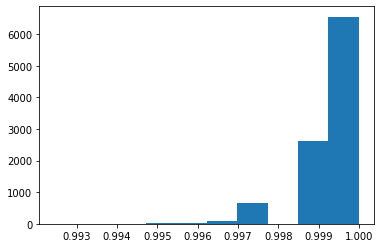

In [218]:
%%time
flag_train = False
isNDVI = False

# get data 
dir_model = "./data/model/RF_HLS.S30.T11SKC.2021056_binary_7K_AllBand.joblib"
dir_score = './data/model/RF_HLS.S30.T11SKC.2021056_binary_7K_AllBand_scores.csv'
starttime = time.process_time()
if flag_train:
    X = df_train.iloc[:,0:13]
    y = df_train['label']
    
    if isNDVI:
        # pre-process ndvi value to -1.0 to 1.0; fill nan to finite value 
        X[X['ndvi']< -1.0]['ndvi'] = -1.0
        X[X['ndvi']> 1.0]['ndvi'] = 1.0
        X[np.isfinite(X['ndvi']) == False]['ndvi'] = np.nan

    # define the model
    model = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=4, random_state=1)#
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1000, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    plt.hist(n_scores)
    print('Repeat times:'.format(), len(n_scores))
    print('Accuracy: %.5f (%.5f)' % (n_scores.mean(), n_scores.std()))

    # fit model with all observations
    model.fit(X,y)
    # save model 
    joblib.dump(model, dir_model)
    # save accuracy 
    scores = pd.DataFrame()
    scores["accuracy"] = n_scores
    scores.to_csv(dir_score, index = False)

    print('Total time used:'.format(), round(time.process_time() - starttime, 1))

Permutation importance - average: Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10',
       'B11', 'B12', 'B8A'],
      dtype='object')
[0.106941, 0.000275, 5e-05, 0.000115, 0.000126, 9.3e-05, 0.000211, 0.000141, 0.000453, 0.016769, 0.000172, 0.00015, 0.000313]


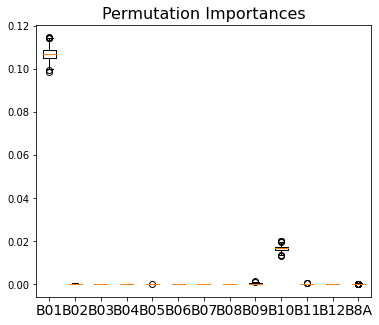

CPU times: user 329 ms, sys: 167 ms, total: 497 ms
Wall time: 34.7 s


In [222]:
%%time
model.fit(X,y)
result = permutation_importance(model, X, y, n_repeats=1000, random_state=42, n_jobs=2)
print('Permutation importance - average:'.format(), X.columns)
print([round(i, 6) for i in result.importances_mean])

# displace feature importance
fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(result.importances.T)
ax.set_title("Permutation Importances", fontsize = 16)
ax.set_xticklabels(labels=X.columns, fontsize=14)
plt.show()

In [ ]:
# for another date 20210501
if False:
    flag_rasterize = True
    tag = 'T11SKC.2021121'
    dir_raster = './HLS_data/RF_train'
    fn = glob.glob(dir_raster + '/*' +tag+'*B*.tif')
    print(fn)
    df = pd.DataFrame()
    for i in range(len(fn)):
        band_name = [n.split('.')[-2] for n in fn]
        r = rasterio.open(fn[i])
        data = pd.DataFrame(r.read().squeeze().reshape(r.height * r.width,1))
        df = pd.concat([df, data], axis=1)

The results showed that the B01 - costal blue band and the B10 - SWIR - Cirrus band (1.375 um) had the most important impacts on SCA prediction.

### Step 3: Run prediction
Predict SCA for the HLS using the model created before.


In [28]:
# apply the model across the entire sense
dir_model = './data/model/RF_HLS.S30.T11SKC.2021056_binary_7K_AllBand.joblib'
dir_out = './data/SCA/HLS/test/'
model = joblib.load(dir_model)
nodata_flag = 9
N_scale = 10000
X_img = df
X_img = X_img/N_scale
X_img.columns = band_name

# run prediction
y_img = model.predict(X_img)

X_img['ndvi'] = (X_img['B08']-X_img['B04'])/(X_img['B08']+X_img['B04'])
X_img[X_img['ndvi']< -1.0]['ndvi'] = -1.0
X_img[X_img['ndvi']> 1.0]['ndvi'] = 1.0
X_img['ndvi'] = np.where(np.isfinite(X_img['ndvi']), X_img['ndvi'], 0) # fill nan by NA

r = rasterio.open(fn[0])
file_out = dir_out + fn[0].split('/')[-1].split('.B')[0]+'_SCA.tif'
ndvi_out = dir_out + fn[0].split('/')[-1].split('.B')[0]+'_NDVI.tif'

out_img = pd.DataFrame()
out_img['label'] = y_img
out_img['ndvi'] = X_img['ndvi']

# Reshape our classification map
img_prediction = out_img['label'].to_numpy().reshape(r.shape)
img_ndvi = out_img['ndvi'].to_numpy().reshape(r.shape)


# save image to file_out

with rasterio.open(
        file_out, "w",
        driver = "GTiff",
        transform = r.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = r.crs,
        width = r.width,
        height = r.height) as dst:
    dst.write(img_prediction, indexes = 1)

with rasterio.open(
        ndvi_out, "w",
        driver = "GTiff",
        transform = r.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = r.crs,
        width = r.width,
        height = r.height) as dst:
    dst.write(img_ndvi, indexes = 1)

In [29]:
# apply the model across the entire sense
dir_model = './data/model/random_forest_20220513_binary_174K.joblib'
dir_out = './data/SCA/HLS/test/'
model = joblib.load(dir_model)
nodata_flag = 9

X_img = df
X_img = X_img/N_scale
X_img.columns = band_name
X_img = X_img[['B02','B03','B04','B08']]
X_img.columns = ['blue','green','red','nir']

# run prediction
y_img = model.predict(X_img)

X_img['ndvi'] = (X_img['nir']-X_img['red'])/(X_img['nir']+X_img['red'])
X_img[X_img['ndvi']< -1.0]['ndvi'] = -1.0
X_img[X_img['ndvi']> 1.0]['ndvi'] = 1.0
X_img['ndvi'] = np.where(np.isfinite(X_img['ndvi']), X_img['ndvi'], 0) # fill nan by NA

r = rasterio.open(fn[0])
file_out = dir_out + fn[0].split('/')[-1].split('.B')[0]+'_SCA_P.tif'
ndvi_out = dir_out + fn[0].split('/')[-1].split('.B')[0]+'_NDVI_P.tif'

out_img = pd.DataFrame()
out_img['label'] = y_img
out_img['ndvi'] = X_img['ndvi']

# Reshape our classification map
img_prediction = out_img['label'].to_numpy().reshape(r.shape)
img_ndvi = out_img['ndvi'].to_numpy().reshape(r.shape)


# save image to file_out

with rasterio.open(
        file_out, "w",
        driver = "GTiff",
        transform = r.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = r.crs,
        width = r.width,
        height = r.height) as dst:
    dst.write(img_prediction, indexes = 1)

with rasterio.open(
        ndvi_out, "w",
        driver = "GTiff",
        transform = r.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = r.crs,
        width = r.width,
        height = r.height) as dst:
    dst.write(img_ndvi, indexes = 1)

In [30]:
X_img = df
X_img = X_img/N_scale
X_img.columns = band_name
X_img['ndsi'] = (X_img['B03']-X_img['B11'])/(X_img['B03']+X_img['B11'])
X_img['ndsi'] = np.where(np.isfinite(X_img['ndsi']), X_img['ndsi'], 0) 
X_img['snow'] = np.where(X_img['ndsi']>0.4, 1, 0) 

r = rasterio.open(fn[0])
ndvi_out = dir_out + fn[0].split('/')[-1].split('.B')[0]+'_NDSI_P.tif'

out_img = pd.DataFrame()
out_img['ndsi'] = X_img['ndsi']

# Reshape our classification map
img_ndvi = out_img['ndsi'].to_numpy().reshape(r.shape)


with rasterio.open(
        ndvi_out, "w",
        driver = "GTiff",
        transform = r.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = r.crs,
        width = r.width,
        height = r.height) as dst:
    dst.write(img_ndvi, indexes = 1)

In [33]:
#validation using ASO data 
th = 0.1 # using 10 cm threshold

# dir_aso = '/data0/kyang33/data/ASO/ori/ASO_3M_SD_USCATE_20210224.tif' 
dir_aso = '/data0/kyang33/data/ASO/ori/topredict20_21/ASO_3M_SD_USCATE_20210429.tif' 
ds_aso = xr.open_rasterio(dir_aso)
dir_chm = '/data0/kyang33/data/ASO/canopy/ASO_3M_CHM_USCATB_20140827.tif'
ds_chm = xr.open_rasterio(dir_chm)
# fn_pred = ['./data/SCA/HLS/test/HLS.S30.T11SKC.2021056T184331.v2.0_NDSI_P.tif',
#            './data/SCA/HLS/test/HLS.S30.T11SKC.2021056T184331.v2.0_SCA.tif',
#            './data/SCA/HLS/test/HLS.S30.T11SKC.2021056T184331.v2.0_SCA_P.tif']
fn_pred = ['./data/SCA/HLS/test/HLS.S30.T11SKC.2021121T183919.v2.0_NDSI_P.tif',
           './data/SCA/HLS/test/HLS.S30.T11SKC.2021121T183919.v2.0_SCA.tif',
           './data/SCA/HLS/test/HLS.S30.T11SKC.2021121T183919.v2.0_SCA_P.tif']
label = []
files = []
num = []
validation_res = pd.DataFrame()
for i in range(len(fn_pred)):
    ds_planet = xr.open_rasterio(fn_pred[i])
    ds_aso_clip = ds_aso.rio.reproject_match(ds_planet)
    ds_chm_clip = ds_chm.rio.reproject_match(ds_planet)
    
    df = pd.DataFrame()
    df['ASO_SD'] = np.reshape(ds_aso_clip.values, (np.product(ds_aso_clip.values.shape),))
    df['predict'] = np.reshape(ds_planet.values, (np.product(ds_planet.values.shape),))
    if i == 0:
        df['predict'] = np.where(df['predict'] > 0.4, 1, 0)
        
    df['obs'] = np.where(df['ASO_SD'] > th, 1.0, 0.0)
    df['chm'] = np.reshape(ds_chm_clip.values, (np.product(ds_chm_clip.values.shape),))
    
    # three labels 0-1 meter, 1 meter - 2 meter; > 2 meter 
    df['label'] = np.where((df['chm'] > 0) & (df['chm'] <= 1), 0.0, np.nan)
    df['label'] = np.where((df['chm'] > 1) & (df['chm'] <= 2), 1.0, df['label'])
    df['label'] = np.where((df['chm'] > 2) & (df['chm'] <= 5), 2.0, df['label'])
    df['label'] = np.where((df['chm'] > 5) & (df['chm'] <= 10), 3.0, df['label'])
    df['label'] = np.where(df['chm'] > 10, 4.0, df['label'])

    df = df[df['ASO_SD'] != -9999]
    df = df[np.isnan(df.obs) == False]
    df = df[np.isnan(df.label) == False]

    label.append('overall')
    num.append(df.shape[0])
    files.append(fn_pred[i])
    validation_res=pd.concat([validation_res, calculate_metrics(df)])
    for j in range(5):
        df_cal = df[df['label'] == j]
        num.append(df_cal.shape[0])
        label.append(j)
        files.append(fn_pred[i])
        validation_res=pd.concat([validation_res, calculate_metrics(df_cal)])

validation_res['th'] = th
validation_res['label']=label
validation_res['pixel_num'] = num
validation_res['file_SCA'] = files
validation_res['file_ASO'] = dir_aso
validation_res.to_csv('./data/SCA/HLS/test/HLS.S30.T11SKC.2021121T183919.v2.0_validation.csv')

In [146]:
fn = glob.glob('./data/SCA/HLS/test/*.csv')
data_vali = pd.DataFrame()
for i in range(len(fn)):
    data = pd.read_csv(fn[i])
    data_vali = pd.concat([data_vali, data], axis = 0)
data_vali['method'] = [i.split('0_')[-1].split('.')[0] for i in data_vali.file_SCA]
data_vali['date'] = [i.split('T11SKC.')[-1].split('.')[0] for i in data_vali.file_SCA]

In [200]:
data_vali
105839/959356

0.11032296665679893

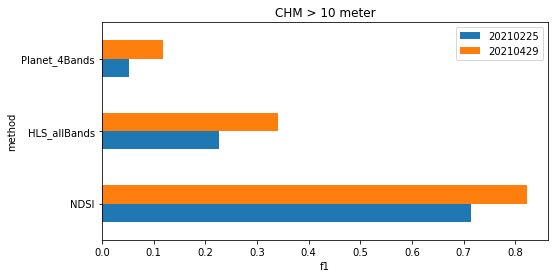

In [196]:
key = 'balanced_accuracy'
key = 'f1'

a = data_vali[key][(data_vali.label == '4') & (data_vali['date'] == data_vali['date'].unique()[0])]
b = data_vali[key][(data_vali.label == '4') & (data_vali['date'] == data_vali['date'].unique()[1])]


plotdata = pd.DataFrame({
    "20210225":a.to_list(),
    "20210429":b.to_list(),
    }, 
    index=['NDSI','HLS_allBands','Planet_4Bands']
)
fig, ax = plt.subplots(figsize = (8,4))
plotdata.plot(kind="barh", ax = ax)
plt.title('CHM > 10 meter')
plt.xlabel(key)
plt.ylabel("method")
plt.legend(loc = 'upper right')




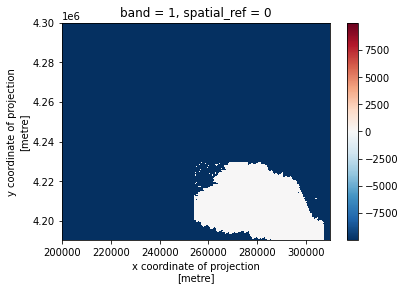

In [282]:
ds_chm_clip.plot()